# Multi-stage continuous-flow manufacturing process

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import zipfile

In [2]:
# Load the dataset
zip_file = "Manufacturing Process.zip"
extract_folder = "manufacturing_process_data"

# Extract the ZIP file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Load the CSV file
data_path = f"{extract_folder}/continuous_factory_process.csv"
data = pd.read_csv(data_path)

# Display the first few rows of the data
print("Data Overview:")
print(data.head())

# Summary statistics
print("\nData Summary:")
print(data.describe())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

Data Overview:
            time_stamp  AmbientConditions.AmbientHumidity.U.Actual  \
0  2019-03-06 10:52:33                                       17.24   
1  2019-03-06 10:52:34                                       17.24   
2  2019-03-06 10:52:35                                       17.24   
3  2019-03-06 10:52:36                                       17.24   
4  2019-03-06 10:52:37                                       17.24   

   AmbientConditions.AmbientTemperature.U.Actual  \
0                                          23.53   
1                                          23.53   
2                                          23.53   
3                                          23.53   
4                                          23.53   

   Machine1.RawMaterial.Property1  Machine1.RawMaterial.Property2  \
0                           11.54                             200   
1                           11.54                             200   
2                           11.54           

In [3]:
# Handle missing values
numeric_columns = data.select_dtypes(include=["number"]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())
print("\nMissing Values After Handling:")
print(data.isnull().sum().head(10))  # Confirm no significant missing values remain

# Extract features from the time_stamp column
data['time_stamp'] = pd.to_datetime(data['time_stamp'], errors='coerce')
data['hour'] = data['time_stamp'].dt.hour
data['minute'] = data['time_stamp'].dt.minute

print("\nTime-based Features Extracted:")
print(data[['time_stamp', 'hour', 'minute']].head())

# Identify input and output columns dynamically
input_features = [col for col in data.columns if "input" in col.lower() or "machine" in col.lower()]
first_stage_outputs = [col for col in data.columns if "Stage1.Output.Measurement" in col and "Actual" in col]
second_stage_outputs = [col for col in data.columns if "Stage2.Output.Measurement" in col and "Actual" in col]

print("\nInput Features Identified:")
print(input_features[:5], f"... ({len(input_features)} total)")

print("\nFirst Stage Outputs Identified:")
print(first_stage_outputs)

print("\nSecond Stage Outputs Identified:")
print(second_stage_outputs)


Missing Values After Handling:
time_stamp                                       0
AmbientConditions.AmbientHumidity.U.Actual       0
AmbientConditions.AmbientTemperature.U.Actual    0
Machine1.RawMaterial.Property1                   0
Machine1.RawMaterial.Property2                   0
Machine1.RawMaterial.Property3                   0
Machine1.RawMaterial.Property4                   0
Machine1.RawMaterialFeederParameter.U.Actual     0
Machine1.Zone1Temperature.C.Actual               0
Machine1.Zone2Temperature.C.Actual               0
dtype: int64

Time-based Features Extracted:
           time_stamp  hour  minute
0 2019-03-06 10:52:33    10      52
1 2019-03-06 10:52:34    10      52
2 2019-03-06 10:52:35    10      52
3 2019-03-06 10:52:36    10      52
4 2019-03-06 10:52:37    10      52

Input Features Identified:
['Machine1.RawMaterial.Property1', 'Machine1.RawMaterial.Property2', 'Machine1.RawMaterial.Property3', 'Machine1.RawMaterial.Property4', 'Machine1.RawMaterialFeederParam

C:\Users\milto\AppData\Local\Temp\ipykernel_17520\1319797301.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['hour'] = data['time_stamp'].dt.hour
C:\Users\milto\AppData\Local\Temp\ipykernel_17520\1319797301.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['minute'] = data['time_stamp'].dt.minute


In [4]:
# Validate if columns were correctly identified
if not first_stage_outputs or not second_stage_outputs:
    raise ValueError("Output columns for one or both stages not found. Check column naming conventions.")

# Split data into features (X) and targets (y) for first-stage predictions
X_stage1 = data[input_features]
y_stage1 = data[first_stage_outputs]

# Train-test split for first stage
X_train_stage1, X_test_stage1, y_train_stage1, y_test_stage1 = train_test_split(
    X_stage1, y_stage1, test_size=0.2, random_state=42
)

# Train the Random Forest model for the first stage
rf_model_stage1 = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model_stage1.fit(X_train_stage1, y_train_stage1)

# Predictions and evaluation for the first stage
y_pred_stage1 = rf_model_stage1.predict(X_test_stage1)
print("\nFirst Stage Prediction Evaluation:")
print("MAE:", mean_absolute_error(y_test_stage1, y_pred_stage1))
print("RMSE:", mean_squared_error(y_test_stage1, y_pred_stage1, squared=False))
print("R²:", r2_score(y_test_stage1, y_pred_stage1))


First Stage Prediction Evaluation:
MAE: 0.4343242863795641
RMSE: 1.239071999333643
R²: 0.6864427665911382


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:
# Feature importance for the first stage
importance_stage1 = rf_model_stage1.feature_importances_
feature_importance_stage1 = pd.DataFrame(
    {"Feature": X_stage1.columns, "Importance": importance_stage1}
).sort_values(by="Importance", ascending=False)

print("\nFirst Stage Feature Importance:")
print(feature_importance_stage1)


First Stage Feature Importance:
                                         Feature    Importance
34         Machine3.MaterialTemperature.U.Actual  1.857635e-01
32                    Machine3.MotorRPM.C.Actual  1.739952e-01
46                Machine5.Temperature4.C.Actual  1.695552e-01
10         Machine1.MaterialTemperature.U.Actual  7.529561e-02
7                Machine1.MotorAmperage.U.Actual  4.815022e-02
8                     Machine1.MotorRPM.C.Actual  4.414455e-02
6             Machine1.Zone2Temperature.C.Actual  3.283442e-02
9             Machine1.MaterialPressure.U.Actual  2.257141e-02
31               Machine3.MotorAmperage.U.Actual  1.924344e-02
33            Machine3.MaterialPressure.U.Actual  1.923783e-02
49             Machine5.ExitTemperature.U.Actual  1.677753e-02
4   Machine1.RawMaterialFeederParameter.U.Actual  1.535733e-02
16  Machine2.RawMaterialFeederParameter.U.Actual  1.406395e-02
28  Machine3.RawMaterialFeederParameter.U.Actual  1.375408e-02
21            Machine2

C:\Users\milto\AppData\Local\Temp\ipykernel_17520\2415915238.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_stage1, x="Importance", y="Feature", palette="viridis")


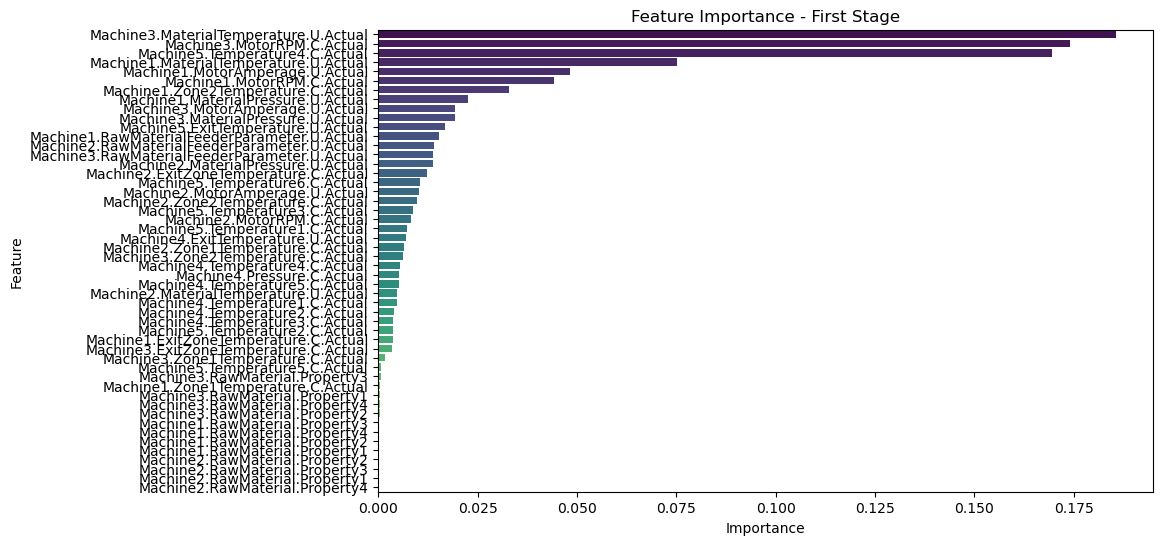

In [6]:
# Plot feature importance for the first stage
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_stage1, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance - First Stage")
plt.show()

In [7]:
# Prepare data for second-stage predictions
X_stage2 = pd.concat([X_stage1, y_stage1], axis=1)  # Include first-stage outputs as inputs for second stage
y_stage2 = data[second_stage_outputs]

# Train-test split for second stage
X_train_stage2, X_test_stage2, y_train_stage2, y_test_stage2 = train_test_split(
    X_stage2, y_stage2, test_size=0.2, random_state=42
)

# Train the Random Forest model for the second stage
rf_model_stage2 = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model_stage2.fit(X_train_stage2, y_train_stage2)

# Predictions and evaluation for the second stage
y_pred_stage2 = rf_model_stage2.predict(X_test_stage2)
print("\nSecond Stage Prediction Evaluation:")
print("MAE:", mean_absolute_error(y_test_stage2, y_pred_stage2))
print("RMSE:", mean_squared_error(y_test_stage2, y_pred_stage2, squared=False))
print("R²:", r2_score(y_test_stage2, y_pred_stage2))


Second Stage Prediction Evaluation:
MAE: 0.421329979394596
RMSE: 1.3119154089795295
R²: 0.7460289764040356


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Second Stage Feature Importance:
                                  Feature    Importance
34  Machine3.MaterialTemperature.U.Actual  4.315337e-01
32             Machine3.MotorRPM.C.Actual  1.777095e-01
45         Machine5.Temperature3.C.Actual  3.769463e-02
49      Machine5.ExitTemperature.U.Actual  3.599231e-02
8              Machine1.MotorRPM.C.Actual  3.111756e-02
..                                    ...           ...
27         Machine3.RawMaterial.Property4  7.753253e-06
15         Machine2.RawMaterial.Property4  4.021359e-06
12         Machine2.RawMaterial.Property1  3.738252e-06
13         Machine2.RawMaterial.Property2  2.241797e-06
14         Machine2.RawMaterial.Property3  8.815233e-07

[65 rows x 2 columns]


C:\Users\milto\AppData\Local\Temp\ipykernel_17520\76257649.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_stage2, x="Importance", y="Feature", palette="viridis")


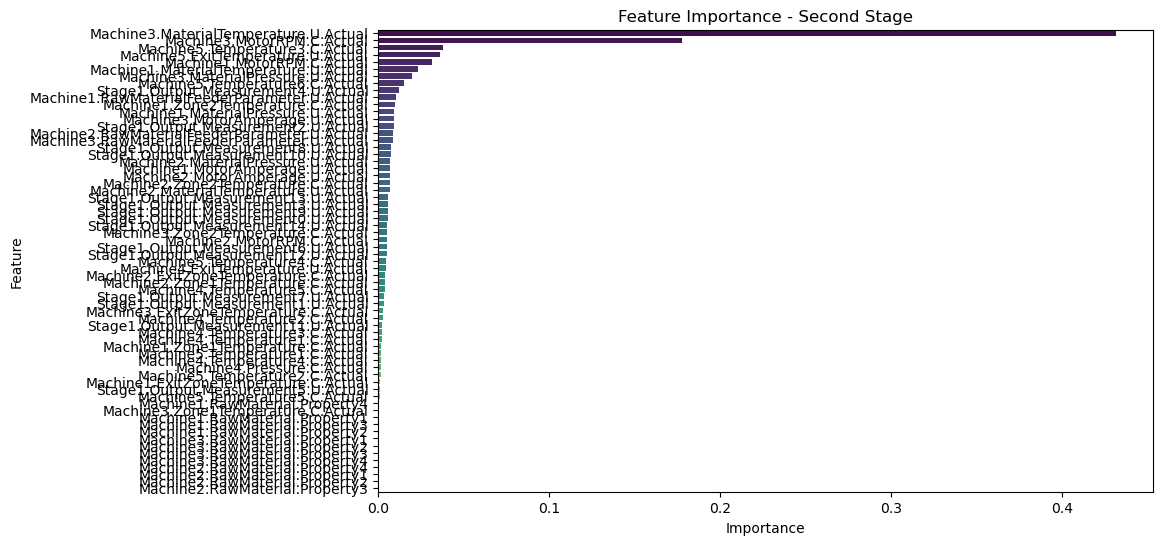

In [8]:
# Feature importance for the second stage
importance_stage2 = rf_model_stage2.feature_importances_
feature_importance_stage2 = pd.DataFrame(
    {"Feature": X_stage2.columns, "Importance": importance_stage2}
).sort_values(by="Importance", ascending=False)

print("\nSecond Stage Feature Importance:")
print(feature_importance_stage2)

# Plot feature importance for the second stage
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_stage2, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance - Second Stage")
plt.show()